In [1]:
# add system path
import sys,os
sys.path.append('/'.join(os.getcwd().split('/')[:-1]))

In [2]:
import nltk
import re
import numpy as np
import collections
import warnings
from sklearn.pipeline import Pipeline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from definitions_toxicity import ROOT_DIR
nltk.download('punkt')

import string
from src.preprocessing.custom_transformers import PunctuationRemover, StopWordsRemover, IntoLowerCase, ShortToLong
from src.visualizers.visualiers import get_stats, get_tf_idf_scores
sns.set(style="darkgrid")

[nltk_data] Downloading package punkt to /home/ievgen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Download Jigsaw database
j_df = pd.read_csv(ROOT_DIR+'/raw_data/jigsaw_dataset.csv')
j_df.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


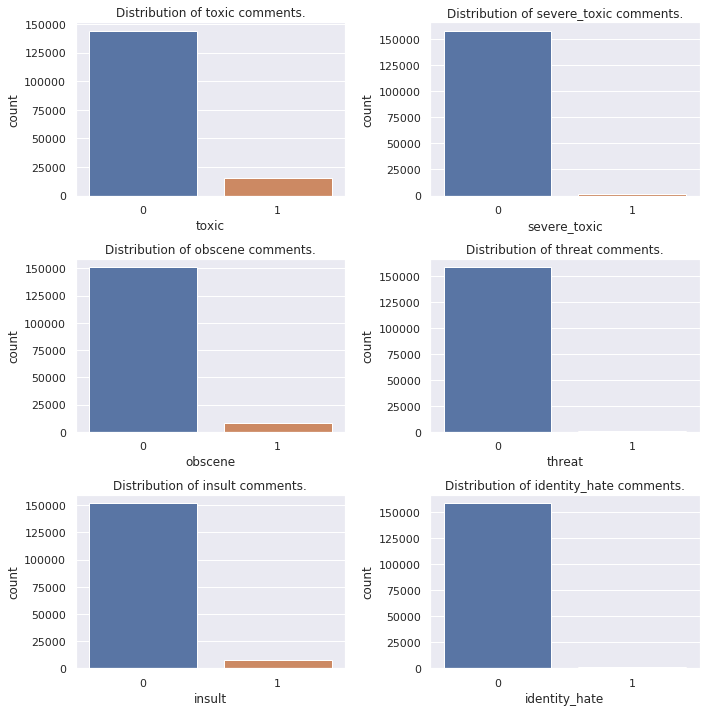

In [4]:
# Target value distribution
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
axes = axes.flatten()
number = 0
for column in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    sns.countplot(x=column, data=j_df, ax=axes[number]).set_title("Distribution of {} comments.".format(column))
    number += 1
plt.tight_layout()
plt.show()

In [5]:
# Add column with number of words
j_df['num_words'] = j_df['comment_text'].apply(
    lambda x: len([token for token in x.split(" ") if token != ""])
)
print(j_df.head(3))

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   

   severe_toxic  obscene  threat  insult  identity_hate  num_words  
0             0        0       0       0              0         42  
1             0        0       0       0              0         17  
2             0        0       0       0              0         42  


Stats for whole dataset:
Min number of words: 1
Max number of words: 1411
Mean number of words: 66.44648463693278
Median number of words: 35.0


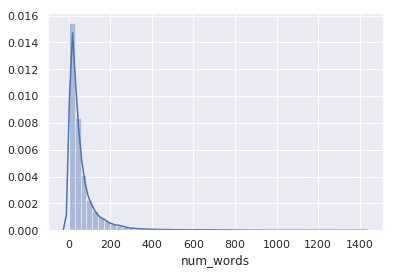

In [6]:
# Print stats for number of words
print("Stats for whole dataset:")
get_stats(j_df, 'words', 'num_words')

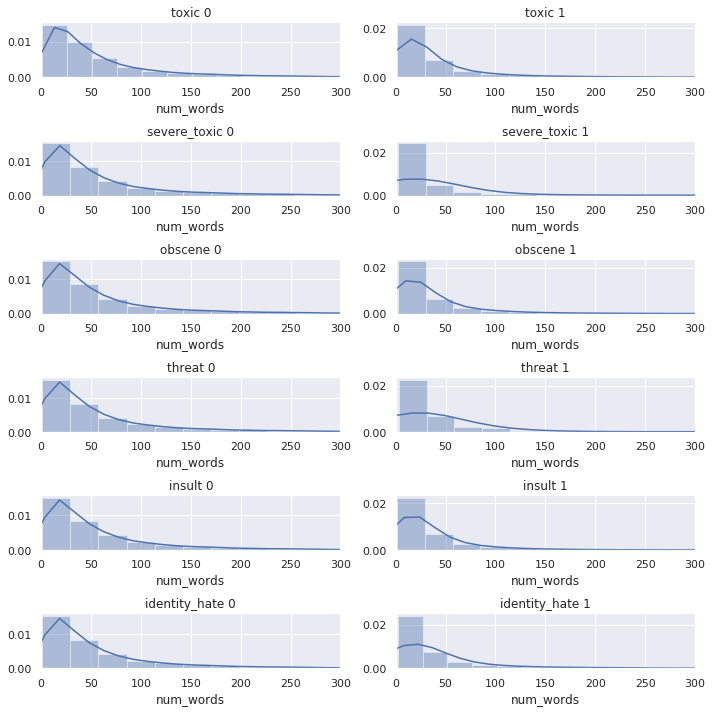

In [7]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10,10))
axes = axes.flatten()
number = 0
for column in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    for i in [0,1]:
        sns.distplot(j_df.loc[j_df[column]==i, 'num_words'], ax=axes[number]).set_title(column+" "+str(i))
        axes[number].set_xlim(0,300)
        number += 1
plt.tight_layout()
plt.show()

Each plot shows that toxic comments tend to be short.

In [8]:
# Download stop words from nltk library
nltk.download('stopwords')
eng_stop_words = nltk.corpus.stopwords.words('english') 

[nltk_data] Downloading package stopwords to /home/ievgen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Add column for text transformations
j_df['prep_text'] = j_df['comment_text'].copy()

# Create pipeline for transformation
pipeline = Pipeline(
    steps=[
        ('contracted', ShortToLong(['prep_text'])),
        ('punctuation', PunctuationRemover(['prep_text'])),
        ('lowercase', IntoLowerCase(['prep_text'])),
        ('stopwords', StopWordsRemover(['prep_text'], eng_stop_words))
    ]
)

In [10]:
# Transform the dataset using created pipeline
# j_df_transf = pipeline.fit_transform(j_df)
# j_df_transf.to_csv(ROOT_DIR + '/temp_data/jigsaw_df_transformed.csv', index=False)
j_df_transf = pd.read_csv(ROOT_DIR + '/temp_data/jigsaw_df_transformed.csv')

In [19]:
# combine all toxic labels into one binary label

j_df_transf['toxic_unified'] = j_df_transf[
    ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
].max(axis=1)

In [20]:
# Count words frequency for toxic comments only
df_tox_uni = get_tf_idf_scores(j_df_transf.loc[j_df_transf['toxic_unified'] == 1, ],
                               column='prep_text', 
                               n_gram=1)
print(df_tox_uni.head(10))

       tf_idf_score      words
4671    9595.757884       bark
26547   7729.388333        pig
14776   6240.763147    fucksex
24222   6202.658157     nipple
2556    5193.793034       aids
4558    4853.754157      balls
6585    4769.091668  buttsecks
37556   4582.240695     wanker
13346   4190.866329    faggots
24449   3971.800851      noobs


Text(0.5, 1.0, 'Toxic comments unigrams by IF-IDF')

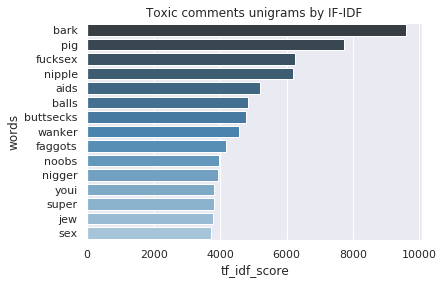

In [23]:
# plot top n words
sns.barplot(
    x="tf_idf_score",
    y="words", 
    data=df_tox_uni.head(15), 
    palette="Blues_d"
).set_title('Toxic comments unigrams by IF-IDF')

In [24]:
# Count bigrams frequency for toxic comments only
df_tox_bi = get_tf_idf_scores(j_df_transf.loc[j_df_transf['toxic_unified'] == 1, ],
                              'prep_text',
                              2)

Text(0.5, 1.0, 'Toxic comments bigrams by IF-IDF')

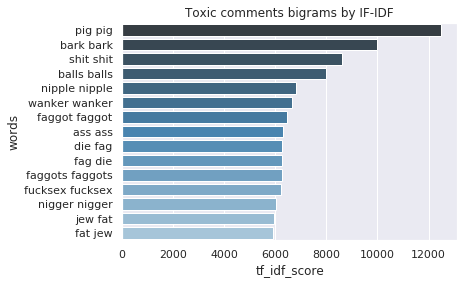

In [25]:
# plot top n words
sns.barplot(
    x="tf_idf_score",
    y="words", 
    data=df_tox_bi.head(15), 
    palette="Blues_d"
).set_title('Toxic comments bigrams by IF-IDF')

Many bigrams looks like repetition of the same word. It deserves additional investigation.

In [26]:
# Delete rows with Nan
print(j_df_transf.shape)
j_df_transf = j_df_transf.dropna()
print(j_df_transf.shape)

(159571, 11)
(159558, 11)


In [27]:
print(j_df_transf.loc[j_df_transf['prep_text'].str.contains('faggot faggot'), 'prep_text'].values)
print("")
print(j_df_transf.loc[j_df_transf['prep_text'].str.contains('shit shit'), 'prep_text'].values)
print("")
print(j_df_transf.loc[j_df_transf['prep_text'].str.contains('ass ass'), 'prep_text'].values)

['faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot faggot fagg

Some cases are trully repetition, but not all of them. Let's try to exclude most obvious with help of regex.

In [28]:
# function for duplicates removal
# https://stackoverflow.com/a/1875706
def duplicates_cutter(df, column, rep_text_list, n_gram):
    df_c = df.copy()
    for rep_text in rep_text_list:
        if n_gram == 'unigram':
            df_c[column] = df_c[column].str.replace(
                r"(({word})([\s,.?\w]{{1,3}}({word}\b))+)".format(word=rep_text), rep_text
            )
        elif n_gram == 'bigram':
            df_c[column] = df_c[column].str.replace(
                r"(({word})([\s,.?\w]{{1,10}}({word}\b))+)".format(word=rep_text), rep_text
            )
        else:
            raise ValueError("Parameter n_gram can be either 'unigram' or 'bigram'")
    return df_c

In [109]:
# # remove bigram duplicates
# j_df_transf_2 = duplicates_cutter(j_df_transf,
#                                   'prep_text',
#                                   df_tox_bi['words'].tolist()[:1000],
#                                   n_gram='bigram')

# # remove unigram duplicates
# j_df_transf_2 = duplicates_cutter(j_df_transf_2,
#                                   'prep_text',
#                                   df_tox_uni['words'].tolist()[:1000],
#                                   n_gram='unigram')

# # save dataframe with duplicates removed
# j_df_transf_2.to_csv(ROOT_DIR + '/temp_data/jigsaw_df_less_spam.csv', index=False)

# load dataframe with duplicates removed
j_df_transf_2 = pd.read_csv(ROOT_DIR + '/temp_data/jigsaw_df_less_spam.csv')

Text(0.5, 1.0, 'Toxic comments bigrams by IF-IDF')

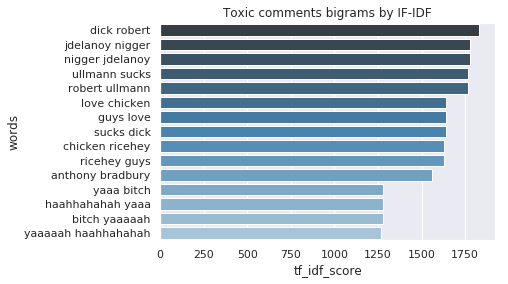

In [110]:
# get df idf scores
df_tox_bi_2 = get_tf_idf_scores(j_df_transf_2.loc[j_df_transf_2['toxic_unified'] == 1, ],
                              'prep_text',
                              2)

# plot top n words
sns.barplot(
    x="tf_idf_score",
    y="words", 
    data=df_tox_bi_2.head(15), 
    palette="Blues_d"
).set_title('Toxic comments bigrams by IF-IDF')

This set of bigrams looks musch more informative and less noisy.

In [111]:
# let's check what happend to those comments we checked previously
print(j_df_transf_2.loc[j_df_transf_2['prep_text'].str.contains('faggot faggot'), 'prep_text'].values)
print("")
print(j_df_transf_2.loc[j_df_transf_2['prep_text'].str.contains('shit shit'), 'prep_text'].values)
print("")
print(j_df_transf_2.loc[j_df_transf_2['prep_text'].str.contains('ass ass'), 'prep_text'].values)

[]

['quit changing shit shithead']

['\n\n disruptive activity \n\n please stop disruptive editing continue vandalize wikipedia paracetamol may blocked editing    🍌 email \n\nyeah add two interesting important new relevant references article indicates potential harm pregnant women paracetamol page removed guys like primary sources ridiculous frankly extreme case wrong wikipedia wife pregnant sure want know potential harm drug would think medical professional would inspired first harm idea fact wikipedia jerks focused sources narrow range whatever takes given article frustrating continued run kind thing would think academic journals taken wikipedia idea actually improved article additions others improve completely escaped much wikipedia culture days wikipedia simply forgotten idea collaboratively edited rather coterie people simply reject edits thread eye needle dozens acronym style guides guys disgusting really standing shoulders millions edits reject thing got namely lots collaborati

They became much cleaner - duplicates of bigrams where reduced to few repetitions or disappeared at all (it's ok as we still has unigram of these words).

Removal of duplicates was supposed to help with tf-idf score of unigrams. But spammed comments make this analysis useless, unless all such messages are cleared.

In [112]:
# Count words frequency for toxic comments only
df_tox_uni_2 = get_tf_idf_scores(j_df_transf_2.loc[j_df_transf_2['toxic_unified'] == 1, ],
                               column='prep_text', 
                               n_gram=1)
print(df_tox_uni_2.head(20))

       tf_idf_score            words
20154   1787.150556               kk
35893   1765.619451          ullmann
36749   1744.306994               uu
29563   1630.199348          ricehey
6012    1562.608349         bradbury
19387   1542.072225         jdelanoy
29731   1482.177563           robert
3216    1398.260380          anthony
38977   1280.156543             yaaa
38979   1280.156543          yaaaaah
16156   1280.156543      haahhahahah
7419    1207.395169          chicken
9437    1110.135752          cuntliz
26084   1050.128414          pennnis
26790   1050.128414            pneis
26094   1050.128414  pensnsnniensnsn
33504   1001.345801            sucks
24108    990.475920           nigger
19664    978.984038            jones
28020    944.610362            pussy


There are still strange words with high score: 'kk' and 'uu'. Let's investigate further.

In [113]:
# 'kk'
print(j_df_transf_2.loc[j_df_transf_2['prep_text'].str.contains(' kk '), 'prep_text'].values)

['found right next one another kk book'
 'fffffffff   uu     uu   cccccc  kk   uuuu\nfffffffff   uu     uu   cccccc\nfffff       uu     uu   cccc\nfffffffff   uu     uu   cccc\nfffffffff   uu     uu   cccc\nfffff       uu     uu   cccc\nfffff       uuuuu   cccccccccccc\nfffff       uuuuu   cccccccccccc'
 'unblock accused editin somethin didnt aint fair n ask 4 apology dont get kk fair enough wrote shit wouldent happened got apology want person accused 2 blocked aswell iam'
 'fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu cccccc kk  f uu c kk fffff uu c

Ok, so 'kk' and 'uu' are repeated many times in one comment. Perfect situation to spoil TF-IDF score. Let's remove them to have a clean graph.

In [114]:
j_df_transf_2['prep_text'] = j_df_transf_2['prep_text'].str.replace('fffff uu cccccc kk', 'fuck')
j_df_transf_2['prep_text'] = j_df_transf_2['prep_text'].str.replace('f uu c kk', 'fuck')
j_df_transf_2['prep_text'] = j_df_transf_2['prep_text'].str.replace('fffffffff   uu     uu   cccccc  kk', 'fuck')

In [115]:
# Count words frequency for toxic comments only
df_tox_uni_2 = get_tf_idf_scores(j_df_transf_2.loc[j_df_transf_2['toxic_unified'] == 1, ],
                               column='prep_text', 
                               n_gram=1)
print(df_tox_uni_2.head(20))

       tf_idf_score            words
35893   1765.619451          ullmann
29563   1630.199348          ricehey
6012    1562.608349         bradbury
19387   1542.072225         jdelanoy
29731   1482.177563           robert
3216    1398.260380          anthony
38977   1280.156543             yaaa
16156   1280.156543      haahhahahah
38979   1280.156543          yaaaaah
7419    1207.395169          chicken
9437    1110.135752          cuntliz
26790   1050.128414            pneis
26084   1050.128414          pennnis
26094   1050.128414  pensnsnniensnsn
33504   1001.345801            sucks
24108    990.475920           nigger
19664    978.984038            jones
28020    944.610362            pussy
13974    910.495131            fired
33644    908.493226       supertr0ll


Scores still have some strage unigrams.

In [116]:
# Other cases of spam
print(j_df_transf_2.loc[j_df_transf_2['prep_text'].str.contains(' yaaaaah '), 'prep_text'].values)

['ah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haahhahahah yaaa bitch yaaaaah haa

In [117]:
# removing specific duplicates
j_df_transf_2['prep_text'] = j_df_transf_2['prep_text'].str.replace(r'(haahhahahah yaaa bitch yaaaaah )+', 'ya bitch ')

In [118]:
print(j_df_transf_2.loc[j_df_transf_2['prep_text'].str.contains('ya bitch'), 'prep_text'].values)

['ah ya bitch haahh']


Text(0.5, 1.0, 'Toxic comments unigrams by IF-IDF')

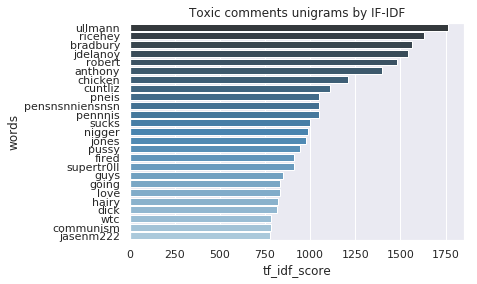

In [119]:
# Count words frequency for toxic comments only
df_tox_uni_3 = get_tf_idf_scores(j_df_transf_2.loc[j_df_transf_2['toxic_unified'] == 1, ],
                               column='prep_text', 
                               n_gram=1)

# plot top n words
sns.barplot(
    x="tf_idf_score",
    y="words", 
    data=df_tox_uni_3.head(25), 
    palette="Blues_d"
).set_title('Toxic comments unigrams by IF-IDF')

Score of unigams now have no strange words that immediately show us an issue with duplicates. But here is another interesting "word": jasenm222 which looks like a user name.

In [124]:
print(j_df_transf_2.loc[j_df_transf_2['prep_text'].str.contains('jasenm222'), 'prep_text'].values)

['fucking bitches reading jasenm222 sucks fat dickfucking bitches reading jasenm222 sucks fat dickfucking bitches reading jasenm222 sucks fat dickfucking bitches reading jasenm222 sucks fat dickfucking bitches reading jasenm222 sucks fat dickfucking bitches reading jasenm222 sucks fat dickfucking bitches reading jasenm222 sucks fat dickfucking bitches reading jasenm222 sucks fat dickfucking bitches reading jasenm222 sucks fat dickfucking bitches reading jasenm222 sucks fat dickfucking bitches reading jasenm222 sucks fat dickfucking bitches reading jasenm222 sucks fat dickfucking bitches reading jasenm222 sucks fat dickfucking bitches reading jasenm222 sucks fat dickfucking bitches reading jasenm222 sucks fat dickfucking bitches reading jasenm222 sucks fat dickfucking bitches reading jasenm222 sucks fat dickfucking bitches reading jasenm222 sucks fat dickfucking bitches reading jasenm222 sucks fat dickfucking bitches reading jasenm222 sucks fat dickfucking bitches reading jasenm222 suck

Here is another instance of "spam" comment, but this time several words are combined into repeating pattern. I am going to stop for duplicate search here and give RNN chance to decide does such pattern lead to toxic comment.